# Trinker

In [809]:
from termcolor import colored
print(colored("""
$$$$$$$$\\        $$\\           $$\\                           $$\\
\\__$$  __|       \\__|          $$ |                          $$ |
   $$ | $$$$$$\\  $$\\ $$$$$$$\\  $$ |  $$\\  $$$$$$\\   $$$$$$\\  $$ | $$$$$$\\ $$\\    $$\\  $$$$$$\\
   $$ |$$  __$$\\ $$ |$$  __$$\\ $$ | $$  |$$  __$$\\ $$  __$$\\ $$ |$$  __$$\\\\$$\\  $$  |$$  __$$\\
   $$ |$$ |  \\__|$$ |$$ |  $$ |$$$$$$  / $$$$$$$$ |$$ |  \\__|$$ |$$ /  $$ |\\$$\\$$  / $$$$$$$$ |
   $$ |$$ |      $$ |$$ |  $$ |$$  _$$<  $$   ____|$$ |      $$ |$$ |  $$ | \\$$$  /  $$   ____|
   $$ |$$ |      $$ |$$ |  $$ |$$ | \\$$\\ \\$$$$$$$\\ $$ |$$\\   $$ |\\$$$$$$  |  \\$  /   \\$$$$$$$\\
   \\__|\\__|      \\__|\\__|  \\__|\\__|  \\__| \\_______|\\__|\\__|  \\__| \\______/    \\_/     \\_______|
================================================================================================

""", 'yellow'))


$$$$$$$$\        $$\           $$\                           $$\
\__$$  __|       \__|          $$ |                          $$ |
   $$ | $$$$$$\  $$\ $$$$$$$\  $$ |  $$\  $$$$$$\   $$$$$$\  $$ | $$$$$$\ $$\    $$\  $$$$$$\
   $$ |$$  __$$\ $$ |$$  __$$\ $$ | $$  |$$  __$$\ $$  __$$\ $$ |$$  __$$\\$$\  $$  |$$  __$$\
   $$ |$$ |  \__|$$ |$$ |  $$ |$$$$$$  / $$$$$$$$ |$$ |  \__|$$ |$$ /  $$ |\$$\$$  / $$$$$$$$ |
   $$ |$$ |      $$ |$$ |  $$ |$$  _$$<  $$   ____|$$ |      $$ |$$ |  $$ | \$$$  /  $$   ____|
   $$ |$$ |      $$ |$$ |  $$ |$$ | \$$\ \$$$$$$$\ $$ |$$\   $$ |\$$$$$$  |  \$  /   \$$$$$$$\
   \__|\__|      \__|\__|  \__|\__|  \__| \_______|\__|\__|  \__| \______/    \_/     \_______|




## Base setup

In [810]:
%pip install timezonefinder

In [811]:
from pathlib import Path
import urllib.request
import pandas as pd
import numpy as np
import geopy.distance
from timezonefinder import TimezoneFinder
import itertools

from pprint import pprint
from pandas.plotting import scatter_matrix

In [812]:
Path("datasets").mkdir(parents=True, exist_ok=True)

### Functions

In [813]:
from pandas.core.arrays.arrow import dtype
def DownloadFile(dataset, directory="datasets/"):
  '''
  args: string, string
  return: string
  '''
  filePath = Path(directory + dataset)
  if not filePath.is_file():
    print("Downloading: ", filePath)
    url = "https://gitlab.com/AdelElHassani/exo_algo_trinker_python/-/raw/master/" + dataset
    urllib.request.urlretrieve(url, filePath)
  return filePath

def PrintNameAndId(targ, prefix=''):
  print(prefix + "{fname} {lname} ({id})".format(
    fname=targ["first_name"]
    , lname=targ["last_name"]
    , pfix=prefix
    , id=targ.name)
  )

def PrintNameAndIdDf(df, prefix=''):
  for i, row in df.iterrows():
    PrintNameAndId(row, prefix)

def ReturnSortedDistArr(grp: pd.DataFrame, targ, size=1):
  tmpDf = grp[(grp.index.values != targ.name)]
  tmpDist = pd.Series(dtype=pd.Float32Dtype)
  for i, row in tmpDf.iterrows():
    tmpDist = pd.concat([
      tmpDist
      , pd.Series(geopy.distance.geodesic(
        (row["latitude"], row["longitude"])
        , (targ["latitude"], targ["longitude"])
      ).km)
    ])
  tmpDist.name="distanceInKm"
  tmpDist.index=tmpDf.index
  tmpDf = pd.merge(tmpDf, tmpDist, left_index=True, right_index=True)
  tmpDf.sort_values(by=["distanceInKm"], inplace=True)
  return tmpDf[:size][[
    "first_name", "last_name"
    , "gender", "looking_for"
    , "pref_movie"
    , "distanceInKm"
  ]]

help(DownloadFile)

Help on function DownloadFile in module __main__:

DownloadFile(dataset, directory='datasets/')
    args: string, string
    return: string



### Loading data and data model

In [814]:
people = pd.read_json(DownloadFile("people.json"))
print(colored('Modele des données :', 'yellow'))
now = pd.Timestamp('now')
people["id"] = people["id"].astype("uint16")
people["date_of_birth"] = people["date_of_birth"].astype('datetime64[ns]')
people["gender"] = people["gender"].astype("category")
people["income"] = people["income"].str.replace('$', '', regex=True).astype("float32")
people["latitude"] = people["latitude"].astype("float32")
people["longitude"] = people["longitude"].astype("float32")
people["looking_for"] = people["looking_for"].astype("category")
people.set_index("id", inplace=True, drop=True)

splitPpl = people[["first_name", "last_name", "pref_movie", "income", "gender", "looking_for", "latitude", "longitude"]].copy(deep=False)
splitPpl["pref_movie"] = splitPpl["pref_movie"].str.split('|')
splitPpl['age'] = (now - people['date_of_birth']).astype('<m8[Y]').astype("uint8")
splitPpl['age'] = splitPpl['age'].where(
  people['date_of_birth'] < now, splitPpl['age'] -  np.timedelta64(100, 'Y').astype("float32")
)

macronExplosion = splitPpl.explode("pref_movie")
macronExplosion["pref_movie"] = macronExplosion["pref_movie"].astype("category")
orderedMovieList = macronExplosion["pref_movie"].value_counts()

print(people.info())
print(orderedMovieList)
people

Modele des données :
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 1000 entries, 1 to 1000
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   first_name     1000 non-null   object        
 1   last_name      1000 non-null   object        
 2   date_of_birth  1000 non-null   datetime64[ns]
 3   email          1000 non-null   object        
 4   gender         1000 non-null   category      
 5   income         1000 non-null   float32       
 6   pref_movie     1000 non-null   object        
 7   latitude       1000 non-null   float32       
 8   longitude      1000 non-null   float32       
 9   looking_for    1000 non-null   category      
dtypes: category(2), datetime64[ns](1), float32(3), object(4)
memory usage: 60.8+ KB
None
Drama                 471
Comedy                304
Romance               156
Action                134
Thriller              134
Crime                 120
Documentary  

first_name     last_name date_of_birth                         email  \
id                                                                           
1         Céline        O'Neal    1966-10-16             joneal0@desdev.cn   
2            Ruì         Cheel    1985-10-10       pcheel1@themeforest.net   
3        Rébecca  BoHlingolsen    1961-07-15  ebohlingolsen2@homestead.com   
4       Marylène        Caveau    1983-03-30          tcaveau3@youtube.com   
5          Åslög       Emerton    1962-03-15        oemerton4@multiply.com   
...          ...           ...           ...                           ...   
996       Adélie          Skim    1998-03-27        askimrn@opensource.org   
997     Béatrice        Bowfin    1961-12-21            jbowfinro@ning.com   
998   Marie-noël     Battleson    1969-09-26   abattlesonrp@eventbrite.com   
999        Léana     Yantsurev    1969-01-15       dyantsurevrq@github.com   
1000        Loïs      Blankett    1986-07-20           cblankettrr@loc.gov   

      gender       income                  pref_movie   latitude   longitude  \
id                                                                             
1     Female  3807.340088                       Drama  59.088337   17.570465   
2       Male   224.479996    Adventure|Romance|Sci-Fi  -7.949922  110.530487   
3       Male  1839.300049                      Horror   9.900466   13.054419   
4     Female  1559.349976                      Comedy  46.816486  127.334183   
5     Female  4637.879883       Comedy|Drama|Thriller  21.681894  102.108971   
...      ...          ...                         ...        ...         ...   
996     Male  4962.450195               Drama|Musical  25.778423 -103.260574   
997     Male  3809.949951  Adventure|Romance|Thriller  39.867985  117.433235   
998     Male  3106.239990              Drama|Thriller  34.134987 -118.150749   
999     Male  4542.040039                 Crime|Drama -16.238260  -44.437061   
1000  Female  3048.959961                       Drama  -7.741499  108.101364   

     looking_for  
id                
1              F  
2              F  
3              F  
4              M  
5              M  
...          ...  
996            F  
997            M  
998            M  
999            F  
1000           F  

[1000 rows x 10 columns]

## Explore data

### Geography

<Axes: xlabel='longitude', ylabel='latitude'>

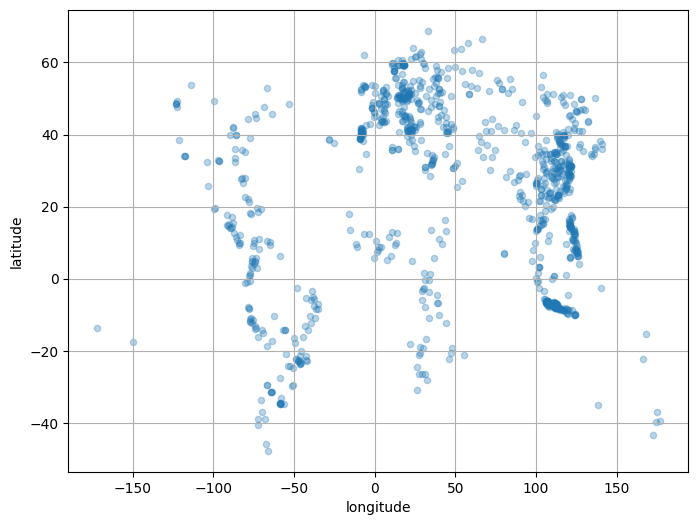

In [815]:
people.plot(
  kind="scatter"
  , x="longitude", y="latitude"
  , grid=True, alpha=0.3, figsize=(8, 6)
)

<Axes: xlabel='longitude', ylabel='latitude'>

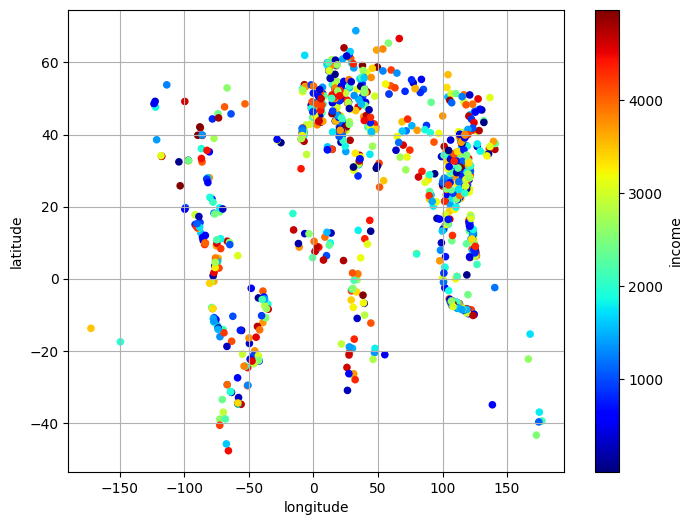

In [816]:
people.plot(
  kind="scatter"
  , x="longitude", y="latitude"
  , grid=True,
  c="income", cmap="jet", colorbar=True,
  legend=True, sharex=False, figsize=(8, 6)
)

### Correlation

In [817]:
correlationMatrix = splitPpl.corr()
correlationMatrix["income"].sort_values(ascending=False)

<ipython-input-817-a37f7796c92a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlationMatrix = splitPpl.corr()


income       1.000000
latitude     0.045437
age         -0.006056
longitude   -0.027070
Name: income, dtype: float64

array([[<Axes: xlabel='income', ylabel='income'>,
        <Axes: xlabel='latitude', ylabel='income'>,
        <Axes: xlabel='longitude', ylabel='income'>,
        <Axes: xlabel='age', ylabel='income'>],
       [<Axes: xlabel='income', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='age', ylabel='latitude'>],
       [<Axes: xlabel='income', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='age', ylabel='longitude'>],
       [<Axes: xlabel='income', ylabel='age'>,
        <Axes: xlabel='latitude', ylabel='age'>,
        <Axes: xlabel='longitude', ylabel='age'>,
        <Axes: xlabel='age', ylabel='age'>]], dtype=object)

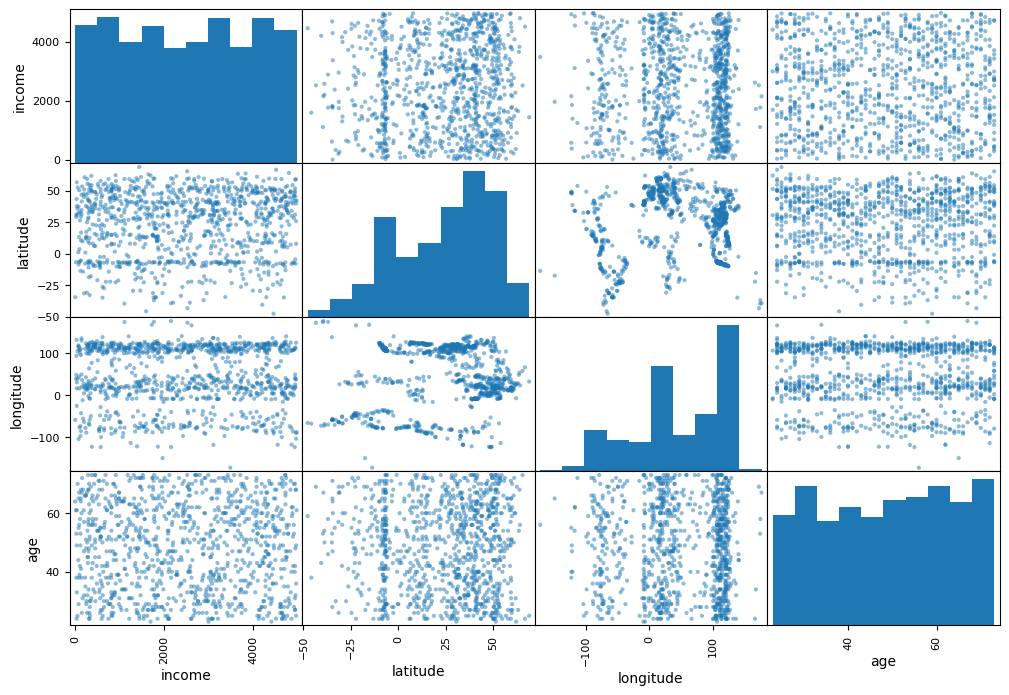

In [818]:
scatter_matrix(splitPpl[["income", "latitude", "longitude", "age"]], figsize=(12, 8))

## Main script

### Level 1

In [819]:
# debut de l'exo
print(colored(''.join(['_' for _ in range(80)]), 'green', 'on_green'))

________________________________________________________________________________


#### Men count

In [820]:
print("Men count:", people["gender"].value_counts()["Male"])

Men count: 491


#### Women count

In [821]:
print("Women count:", people["gender"].value_counts()["Female"])

Women count: 509


#### Looking for men count

In [822]:
print("Looking for M count:", people["looking_for"].value_counts()["M"])

Looking for M count: 499


#### Looking for women count

In [823]:
print("Looking for F count:", people["looking_for"].value_counts()["F"])

Looking for F count: 501


#### Income above 2000$

In [824]:
print("People above $2k income:", people.loc[people.income > 2000].shape[0])

People above $2k income: 588


#### People who like dramas

In [825]:
print("Count of people who like dramas:"
  , macronExplosion["pref_movie"].value_counts()["Drama"])

Count of people who like dramas: 471


#### Women who like scifi

In [826]:
tmp = macronExplosion.loc[macronExplosion.gender == "Female"]
print("Count of women who like sci-fi:"
  , tmp["pref_movie"].value_counts()["Sci-Fi"])

Count of women who like sci-fi: 26


### Level 2

In [827]:
print(
  colored('LEVEL 2' + ''.join(['_' for _ in range(73)])
  , 'green'
  , 'on_green')
)

LEVEL 2_________________________________________________________________________


#### People who like documentaries and have an income above $1482

In [828]:
tmp = macronExplosion.loc[macronExplosion.income >= 1482]
print("Count of people who like documentaries and have an income about $1482:"
  , tmp["pref_movie"].value_counts()["Documentary"])

Count of people who like documentaries and have an income about $1482: 71


#### Last names, first names, ids, and incomes of people who have an income above $4000

In [829]:
print("['Rich people']")
PrintNameAndIdDf(people.loc[people.income > 4000])

['Rich people']
Åslög Emerton (5)
Rébecca Garey (16)
Görel Georgeon (21)
Anaé Barbary (31)
Maëline Richmond (32)
Vénus Doxsey (33)
Ruò Brunner (36)
Östen Bourdas (37)
Géraldine Rout (45)
Sòng Eadmead (51)
Michèle Pask (58)
Tán Trubshaw (62)
Lauréna Cawood (65)
Marie-hélène Brassington (72)
Gérald Lamplough (76)
Eléa Roberson (78)
Geneviève Blaszczynski (80)
Loïs Dron (81)
Méng Corking (85)
Inès Falcus (92)
Thérèse Elix (95)
Zhì Bugler (97)
Annotée Drohun (115)
Cléopatre Sloy (116)
Lèi Gillett (120)
Mårten Fearnall (123)
Mélina Janiak (124)
Lyséa Pepler (127)
Angélique Auston (142)
Léandre Pacheco (149)
Eliès Spelwood (152)
Pò Berens (154)
Magdalène Weerdenburg (155)
Almérinda Attoe (159)
Bécassine Maccrie (167)
Séverine Stubbings (168)
Marie-noël Happs (170)
Cécile Roz (182)
Cinéma Kivelhan (183)
Mårten Duncklee (184)
Marie-hélène Haulkham (190)
Anaëlle Pailin (197)
Adélie Murricanes (199)
Wá Ratnage (201)
Athéna Wakely (203)
Kévina Punch (207)
Stévina Sifflett (209)
Maëlle Corter (212

#### Name and id of male with the highest income

In [861]:
result = people.loc[people.gender == "Male"]
PrintNameAndId(result.loc[result["income"].idxmax()], "['Richest person'] ")

['Richest person'] Salomé Borzoni (335)


#### Mean income

In [862]:
print("['Mean income']", people["income"].mean())

['Mean income'] 2481.2717


#### Median income

In [863]:
print("['Median income']", people["income"].median())

['Median income'] 2503.25


#### Living in the northern hemisphere count

In [864]:
result = len(people.loc[people["latitude"] > 0])
print("Count of people living north:", result)

Count of people living north: 769


#### Living in the southern hemisphere count

In [865]:
result = people.loc[people["latitude"] <= 0]
print("Median income of people living south:", result["income"].mean())

Median income of people living south: 2355.6565


### Level 3

In [866]:
print(colored('LEVEL 3' + ''.join(['_' for _ in range(73)]), 'green', 'on_green'))

LEVEL 3_________________________________________________________________________


#### Name and id of person living closest to Benerice Cawt

In [867]:
target = people.loc[
  (people.first_name == "Bérénice")&(people.last_name == "Cawt")
].iloc[0]
PrintNameAndId(target, "['Geolocalisation'] ")
print("-------------------")
print(ReturnSortedDistArr(people, target)[[
    "first_name", "last_name"
    , "distanceInKm"
  ]])

['Geolocalisation'] Bérénice Cawt (61)
-------------------
    first_name last_name  distanceInKm
id                                    
833         Dù   Houlden    146.191435


#### Name and id of person living closest to Rui Brach

In [868]:
target = people.loc[
  (people.first_name == "Ruì")&(people.last_name == "Brach")
].iloc[0]
PrintNameAndId(target, "['Geolocalisation'] ")
print("-------------------")
print(ReturnSortedDistArr(people, target)[[
    "first_name", "last_name"
    , "distanceInKm"
  ]])

['Geolocalisation'] Ruì Brach (558)
-------------------
    first_name  last_name  distanceInKm
id                                     
984     Miléna  McCreadie     78.563825


#### Name and id of the 10 persons living closest to Josee Boshard

In [869]:
target = people.loc[
  (people.first_name == "Josée")&(people.last_name == "Boshard")
].iloc[0]
PrintNameAndId(target, "['Geolocalisation'] ")
print("-------------------")
print(ReturnSortedDistArr(people, target, 10)[[
    "first_name", "last_name"
    , "distanceInKm"
  ]])

['Geolocalisation'] Josée Boshard (594)
-------------------
        first_name   last_name  distanceInKm
id                                          
525   Marie-hélène     Sellner      6.762023
930          Maëly   Lambswood      7.823676
231          Östen       Leddy     11.501929
101      Geneviève  Humberston     98.130903
577       Torbjörn       Jesse    211.399438
375       Marylène      Lathan    224.447429
166        Léandre   Hackleton    228.707134
841    Marie-josée     Yusupov    234.465387
443  Marie-thérèse      Guslon    243.553325
424      Françoise     Wardrop    247.554240


#### Name and id of the 23 persons working at Google

In [870]:
print("\t['Google']")
PrintNameAndIdDf(people.loc[people["email"].str.contains("google")])

	['Google']
Geneviève Blaszczynski (80)
Aí Hazzard (238)
Görel Thackwray (249)
Marlène Kite (254)
Béatrice Haskayne (256)
Eléa Dinsell (294)
Céline Gayton (337)
Estée Huertas (345)
Garçon Crimmins (347)
Yóu Weymont (356)
Andrée de Broke (367)
Aurélie Fernan (390)
Daphnée Sprackling (414)
Françoise Wardrop (424)
Marie-thérèse Guslon (443)
Mégane Logsdail (466)
Östen Sandercock (640)
Görel Arney (692)
Gwenaëlle Owbrick (761)
Maëline Jelk (853)
Léa Grove (947)
Almérinda Meddemmen (993)
Josée Ambroz (994)


#### Oldest person

In [871]:
result = splitPpl.loc[splitPpl["age"].idxmax()]
print("\t['Old']")
print(result[["age", "first_name", "last_name"]])

	['Old']
age                  73
first_name    Geneviève
last_name       Whitlaw
Name: 39, dtype: object


#### Youngest person

In [872]:
result = splitPpl.loc[splitPpl["age"].idxmin()]
print("\t['Young']")
print(result[["age", "first_name", "last_name"]])

	['Young']
age                 23
first_name    Judicaël
last_name      Fortnon
Name: 83, dtype: object


#### Mean of age difference

In [873]:
pairs = list(itertools.combinations(splitPpl['age'], 2))
differences = [abs(x - y) for x, y in pairs]
mean_difference = np.mean(differences)

print("['Mean age difference']")
print(mean_difference)

['Mean age difference']
17.006382382382384


### Level 4

#### Most popular movie

In [874]:
print("['Most popular movie']")
print(orderedMovieList.index[0])

['Most popular movie']
Drama


#### Ordered array of most popular movies

In [875]:
print("['Most popular movies']")
for mov in orderedMovieList.index:
  print(mov)

['Most popular movies']
Drama
Comedy
Romance
Action
Thriller
Crime
Documentary
Adventure
Horror
Sci-Fi
Fantasy
Children
Mystery
Musical
War
Animation
Western
Film-Noir
IMAX
(no genres listed)


#### List of most popular movies with count of people who like them

In [876]:
print("['Most popular movies with count']")
orderedMovieList

['Most popular movies with count']


Drama                 471
Comedy                304
Romance               156
Action                134
Thriller              134
Crime                 120
Documentary           104
Adventure              87
Horror                 83
Sci-Fi                 51
Fantasy                49
Children               42
Mystery                39
Musical                37
War                    35
Animation              34
Western                33
Film-Noir              14
IMAX                    6
(no genres listed)      5
Name: pref_movie, dtype: int64

#### Mean age of people who prefers films noirs

In [877]:
tmp = macronExplosion[macronExplosion["pref_movie"] == "Film-Noir"]
print("['Mean age of film-noir fans']")
tmp["age"].mean()

['Mean age of film-noir fans']


46.285714285714285

#### Mean age of women who like dramas and live in the paris timezone

In [878]:
tzf = TimezoneFinder()

tmp = macronExplosion[macronExplosion["pref_movie"] == "Drama"]
tmp = tmp[
  (tmp.gender == "Female")
]
for i, row in tmp.iterrows():
  if tzf.timezone_at(lng=row.longitude, lat=row.latitude) != "Europe/Paris":
    tmp.drop([i], inplace=True)
print("['Mean age of women who watch dramas']")
tmp["age"].mean()

['Mean age of women who watch dramas']


57.142857142857146

#### Closest Male looking_for M who is looking_for M. They must have at least one pref_movie in common.

In [879]:
from numpy.lib.function_base import delete
tmp = macronExplosion.loc[
  ((macronExplosion.gender == "Male")&(macronExplosion.looking_for == "M"))
].copy(deep=False)

closestMatch = [None, None]
shortestDist = None
grouped = tmp.groupby("pref_movie")[["pref_movie", "first_name", "last_name", "gender", "looking_for", "latitude", "longitude"]]
for name, group in grouped:
  i = 0
  while 1:
    size = len(group)
    if (size <= 1) | (size <= i):
      break
    result = ReturnSortedDistArr(group, group.iloc[i])
    if shortestDist == None or shortestDist > result.iloc[0].distanceInKm:
      shortestDist = result.iloc[0].distanceInKm
      closestMatch = [group.iloc[i], result.iloc[0]]
    group.drop(group.iloc[i].name, inplace=True)
    i+=1

print(
  "      ['Manly match']\n"
  +"{luckyUsr0}\n".format(luckyUsr0=closestMatch[0][[
    "first_name"
    , "last_name"
    , "gender"
    , "looking_for"
    , "pref_movie"
  ]])
  +"v^v^v^v^v^v^v^v^v^v^v^v^v^\n"
  +"v^ {dist} km v^\n".format(dist=shortestDist)
  +"v^v^v^v^v^v^v^v^v^v^v^v^v^\n"
  +"{luckyUsr1}".format(luckyUsr1=closestMatch[1][[
    "first_name"
    , "last_name"
    , "gender"
    , "looking_for"
    , "pref_movie"
  ]])
)


      ['Manly match']
first_name         Anaëlle
last_name           Pailin
gender                Male
looking_for              M
pref_movie     Documentary
Name: 197, dtype: object
v^v^v^v^v^v^v^v^v^v^v^v^v^
v^ 4.586635491554671 km v^
v^v^v^v^v^v^v^v^v^v^v^v^v^
first_name        Torbjörn
last_name             Japp
gender                Male
looking_for              M
pref_movie     Documentary
Name: 401, dtype: object


#### Pairs of men and women who share the same movie preferences

In [880]:
tmp = people.loc[
  ((people.gender == "Male")&(people.looking_for == "F"))
  |
  ((people.gender == "Female")&(people.looking_for == "M"))
]

test = None
for name, group in tmp.groupby(["pref_movie"])[["pref_movie",  "first_name",  "last_name",  "gender", "looking_for", "latitude", "longitude"]]:
  i = 0
  x = 0
  y = 1
  humans = [group.loc[group.gender == "Male"], group.loc[group.gender == "Female"]]
  size = [len(humans[0]), len(humans[1])]
  if (size[0] == 0) or (size[1] == 0):
    continue
  if size[0] >= size[1]:
    x = 1
    y = 0

  while 1:
    if (size[x] == i):
      break
    print(
      "-----------------------------------------------------------------\n"
      +"['Movie match'] {movie}\n".format(
        movie=humans[y].iloc[i][["pref_movie"]].values)
      , ReturnSortedDistArr(
        humans[x]
        , humans[y].iloc[i]
      )[["first_name",  "last_name",  "gender", "looking_for", "distanceInKm"
    ]])
    PrintNameAndId(humans[y].iloc[i], prefix="MATCHED WITH: ")
    i+=1

-----------------------------------------------------------------
['Movie match'] ['(no genres listed)']
     first_name last_name  gender looking_for  distanceInKm
id                                                        
869   Laurélie    Dincke  Female           M   6700.738954
MATCHED WITH: Erwéi Loveredge (169)
-----------------------------------------------------------------
['Movie match'] ['Action']
     first_name   last_name  gender looking_for  distanceInKm
id                                                          
962       Loïc  Barrabeale  Female           M   4782.749697
MATCHED WITH: Aí Hazzard (238)
-----------------------------------------------------------------
['Movie match'] ['Action']
     first_name last_name  gender looking_for  distanceInKm
id                                                        
502        Tán   Keysall  Female           M   1421.318374
MATCHED WITH: Maëline Please (282)
-----------------------------------------------------------------
[

#### Match

In [881]:
print(colored('MATCH' + ''.join(['_' for _ in range(73)]), 'green', 'on_green'))

MATCH_________________________________________________________________________


In [882]:
"""
    On match les gens avec ce qu'ils cherchent (homme ou femme).
    La différences d'age dans un couple doit être inférieure à 25% (de l'age du plus agé des deux)
    Les gens qui travaillent chez google ne peuvent qu'être en couple entre eux.
    Quelqu'un qui n'aime pas les Drama ne peux pas être en couple avec quelqu'un qui les aime.
    Quelqu'un qui aime les films d'aventure doit forcement être en couple avec quelqu'un qui aime aussi
    les films d'aventure.

    On prend en priorité ceux qui ont le plus de gouts en commun.
    Puis ceux qui sont les plus proches.
    ߷    ߷    ߷    Créer le plus de couples possibles.                  ߷    ߷    ߷
    ߷    ߷    ߷    Mesurez le temps de calcul de votre fonction         ߷    ߷    ߷
    ߷ q   ߷    ߷    Essayez de réduire le temps de calcul au maximum     ߷    ߷    ߷

"""



"\n    On match les gens avec ce qu'ils cherchent (homme ou femme).\n    La différences d'age dans un couple doit être inférieure à 25% (de l'age du plus agé des deux)\n    Les gens qui travaillent chez google ne peuvent qu'être en couple entre eux.\n    Quelqu'un qui n'aime pas les Drama ne peux pas être en couple avec quelqu'un qui les aime.\n    Quelqu'un qui aime les films d'aventure doit forcement être en couple avec quelqu'un qui aime aussi\n    les films d'aventure.\n\n    On prend en priorité ceux qui ont le plus de gouts en commun.\n    Puis ceux qui sont les plus proches.\n    ߷    ߷    ߷    Créer le plus de couples possibles.                  ߷    ߷    ߷\n    ߷    ߷    ߷    Mesurez le temps de calcul de votre fonction         ߷    ߷    ߷\n    ߷ q   ߷    ߷    Essayez de réduire le temps de calcul au maximum     ߷    ߷    ߷\n\n"